#**Multiclass Logistic Regression**

The goal of this exercise was to build a classifier for a multi-class scenario. The addressed problem was the identification of human activities using smartphone data, from a dataset containing attributes in the time and frequency domains extracted from accelerometer and gyroscope signals of a smartphone. The labels of the samples indicate the performed activity at a given moment.

The dataset was previously divided into 7352 training samples and 2947 test samples, with each sample described by 561 temporal or spectral attributes. For this dataset, the labels are divided into 6 classes.


##**Import libraries**

In [2]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
import math
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import glob
from google.colab import drive
from google.colab import files
import warnings

drive.mount('/content/drive')

Mounted at /content/drive


##**Load data**

In [3]:
list_files = glob.glob('/content/drive/My Drive/smartphone/***.txt')
print(list_files)
print(len(list_files))
data = {}
for i in range(0,4):
  data[f'{list_files[i][35:-4]}'] = tuple([pd.read_csv(list_files[i],delim_whitespace=True, header=None)])
'''The numbers in list_files[i] index --> '[35:-4]' represent the number of characters from the beginning of the directory
to the beginning of the filename (35) and the characters number of the file extension (-4) i.e.: .txt '''

X_train, X_test, y_train, y_test = data['X_train'][0],data['X_test'][0],data['y_train'][0],data['y_test'][0]

['/content/drive/My Drive/smartphone/X_test.txt', '/content/drive/My Drive/smartphone/X_train.txt', '/content/drive/My Drive/smartphone/y_train.txt', '/content/drive/My Drive/smartphone/y_test.txt']
4


In [4]:
#Creating dict
activity = {1 :'Caminhada',2 :'Subindo escadas',3 :'Descendo escadas',4 :'Sentado',5 :'Em pé',6 :'Deitado'}

###**Concatenate values**

In [5]:
#Rename column
y_train = y_train.rename(columns={0: "label"})
#concatenate
train = pd.concat([X_train,y_train],axis=1)

###**Balance measure**

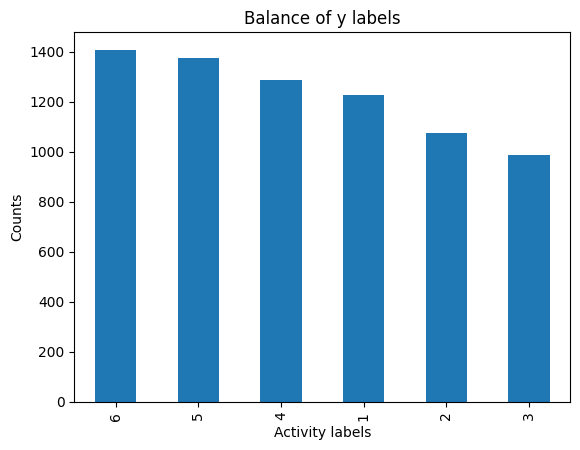

In [6]:
y_train['label'].value_counts().plot(kind='bar')
plt.xlabel('Activity labels')
plt.ylabel('Counts')
plt.title('Balance of y labels')
plt.show()

classes are unbalanced


###**Oversamplimg data with SMOTE**

SMOTE (Synthetic Minority Oversampling Technique)

Firstly, we observed the distribution of labels in the training samples and concluded that the dataset was imbalanced, which could potentially impact the model's performance. To address this issue, we employed the Synthetic Minority Oversampling Technique (SMOTE) to oversample the data and achieve a balanced set. The technique works by creating synthetic samples for classes with fewer samples, randomly choosing one of the k nearest neighbors to generate similar, adjusted samples. We used 5 nearest neighbors (standard parameter) as the parameter k, resulting in a balanced training set with 8442 samples, with 1407 samples for each class.



length of original data is  7352
length of oversampled data is  8442 

Number of samples in Caminhada 1407
Proportion of samples in Caminhada 0.16666666666666666
Number of samples in Subindo escadas 1407
Proportion of samples in Subindo escadas 0.16666666666666666
Number of samples in Descendo escadas 1407
Proportion of samples in Descendo escadas 0.16666666666666666
Number of samples in Sentado 1407
Proportion of samples in Sentado 0.16666666666666666
Number of samples in Em pé 1407
Proportion of samples in Em pé 0.16666666666666666
Number of samples in Deitado 1407
Proportion of samples in Deitado 0.16666666666666666


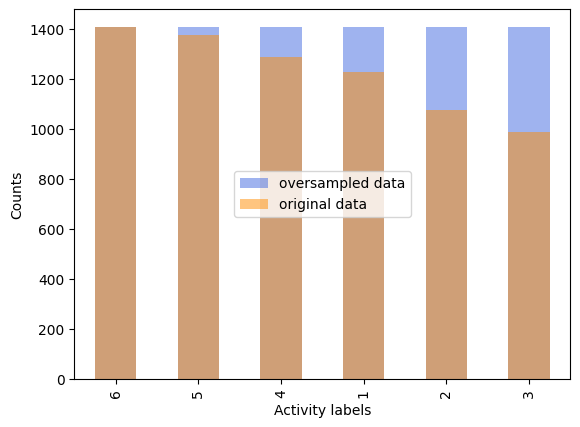

In [8]:
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore') #Dont show deprecated warnings from colab
os = SMOTE(random_state=0)

columns = X_train.columns

os_X_train,os_y_train = os.fit_resample(X_train, y_train)
os_X_train = pd.DataFrame(data=os_X_train,columns=columns )
os_y_train = pd.DataFrame(data=os_y_train,columns=['label'])
# we can Check the numbers of our data
print("\nlength of original data is ",len(X_train))
print("length of oversampled data is ",len(os_X_train),'\n')
for i in range(1,7):
  print(f"Number of samples in {activity[i]}",len(os_y_train[os_y_train['label']==i]))
  print(f"Proportion of samples in {activity[i]}",len(os_y_train[os_y_train['label']==i])/len(os_X_train))
ax = os_y_train['label'].value_counts().plot(kind='bar',alpha=0.5,color = 'royalblue',label='oversampled data')
y_train['label'].value_counts().plot(kind='bar',alpha=0.5,color = 'darkorange',ax=ax,label='original data')
plt.xlabel('Activity labels')
plt.ylabel('Counts')
plt.legend(loc='center')
plt.show()


In [9]:
desc = os_X_train.describe() #variables summary
desct = desc.transpose() #transpose to check all the summaries
desct.describe() #summary's summary to check if data is normalized


,count,mean,std,min,25%,50%,75%,max
count,561.0,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,8442.0,-0.492352,0.286254,-0.990303,-0.720630,-0.529901,-0.303933,0.978355
std,0.0,0.422575,0.136885,0.050292,0.418278,0.481217,0.505940,0.069234
min,8442.0,-0.982010,0.039070,-1.000000,-1.000000,-1.000000,-1.000000,0.465197
25%,8442.0,-0.850043,0.192787,-1.000000,-0.999691,-0.958604,-0.769231,1.000000
50%,8442.0,-0.624464,0.268341,-1.000000,-0.985230,-0.732105,-0.370527,1.000000
75%,8442.0,-0.097370,0.363660,-1.000000,-0.438337,-0.101225,0.102433,1.000000
max,8442.0,0.812808,0.758963,-0.493874,0.832975,0.927383,0.993492,1.000000


The mean of the minimums is -0.99, and the 1st, 2nd, and 3rd quartiles are -1.

The mean of the maximums is 0.97, and the 1st, 2nd, and 3rd quartiles are 1.

**We can conclude that the variables are alrady normalized from -1 to 1.**


In [10]:
#redefine variables
X_train = os_X_train
y_train = os_y_train

##**Multiclass Logistic Regression fit**

We trained a logistic regression classifier with L2 penalty using 5-fold cross-validation. In order to improve our classifier, we conducted a search for the best parameters through the GridSearch function, where we tested the hyperparameter C and the training algorithms "one-vs-rest" and "multinomial."


In [12]:
model = LogisticRegression(penalty='l2')
folds = KFold(5,random_state = 5, shuffle=True)

# define grid
grid = dict()
grid['C'] = np.logspace(-4, 4, 20)
grid['multi_class'] = ['ovr', 'multinomial']

# define search
search = GridSearchCV(model, grid, scoring='neg_log_loss', cv=folds)

# perform the search
results = search.fit(os_X_train, os_y_train)
C = results.best_params_['C']
multi = results.best_params_['multi_class']
print('best score: ',results.best_score_)
print('best C: ',C)
print('best multi class: ',multi)

#Fit tunned model
model = LogisticRegression(C=4.28,multi_class='ovr',penalty='l2')
model.fit(os_X_train, os_y_train)
#Accuracy
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
f1 = f1_score(y_test,predicted_classes,average='weighted')
print(f"Acuracy of the tunned model:{round(accuracy*100,2)}%")
print(f"F1 of the tunned model:{round(f1*100,2)}%")

best score:  -0.04370330883995853
best C:  11.288378916846883
best multi class:  ovr
Acuracy of the tunned model:96.23%
F1 of the tunned model:96.22%


In [13]:
#Checking performance our model with classification report.
print(classification_report(y_test,predicted_classes))

              precision    recall  f1-score   support

           1       0.94      1.00      0.97       496
           2       0.97      0.95      0.96       471
           3       1.00      0.97      0.98       420
           4       0.97      0.88      0.92       491
           5       0.90      0.97      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



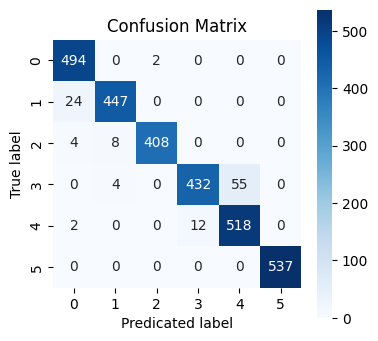

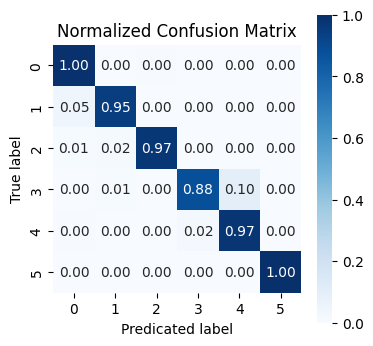

In [28]:
# creating a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_classes)
df_cm = pd.DataFrame(cm)

cm_norm = cm / cm.astype(np.float).sum(axis=1)
df_cm_norm = pd.DataFrame(cm_norm)

plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='d',cmap=plt.cm.Blues)
plt.title("Confusion Matrix",fontsize = 12)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

plt.figure(figsize=(4,4))
sns.heatmap(df_cm_norm, square=True, fmt=".2f", annot=True,cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 12)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

##**KNN**

KNN (k-nearest neighbours) classifier – KNN or k-nearest neighbours is the simplest classification algorithm. This classification algorithm does not depend on the structure of the data. Whenever a new example is encountered, its k nearest neighbours from the training data are examined. Distance between two examples can be the euclidean distance between their feature vectors. The majority class among the k nearest neighbours is taken to be the class for the encountered example.


In [29]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

k = []
accuracy =[]
f1 = []

for n in range (1,31):
  k.append(n)
  knn = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
  predicted_knn = knn.predict(X_test)

  # accuracy on X_test
  accuracy.append(accuracy_score(y_test,predicted_knn))
  f1.append(f1_score(y_test,predicted_knn,average='weighted'))

In [30]:
table = pd.DataFrame()
table['k'] = k
table['accuracy'] = accuracy
table['F1'] = f1
table.head()

,k,accuracy,F1
0,1,0.874109,0.873867
1,2,0.867662,0.866760
2,3,0.890397,0.890035
3,4,0.888361,0.887824
4,5,0.899220,0.898725


In [31]:
#find best k and train classifier
best_k_accuracy = table['k'][table['accuracy'].idxmax()]
best_k_f1 = table['k'][table['F1'].idxmax()]

#accuracy
knn = KNeighborsClassifier(n_neighbors = best_k_accuracy,p=1).fit(X_train, y_train) #p=1 --> manhattan_distance
predicted_knn = knn.predict(X_test)

print(f"Model accuracy for k={best_k_accuracy}: {accuracy_score(y_test,predicted_knn)}")

print(f"Model f1 score for k={best_k_f1}: {f1_score(y_test,predicted_knn,average='weighted')}")

Model accuracy for k=21: 0.9246691550729556
Model f1 score for k=21: 0.9238470328267548


We utilized the KNN model (K Nearest Neighbors) for the classification of the dataset, varying k from 1 to 30, calculating the F1 score of the model for each k. The best F1 score was achieved for k = 21 and was 0.9111. Subsequently, we performed a GridSearch to find the optimal parameter p, related to the distance metric used (Minkowski metric, Euclidean distance, or Manhattan distance). The best result was obtained using the Manhattan distance, and the F1 score of the model was then 0.9238.


In [32]:
print(classification_report(y_test, predicted_knn))

              precision    recall  f1-score   support

           1       0.88      0.97      0.93       496
           2       0.88      0.93      0.90       471
           3       0.96      0.79      0.86       420
           4       0.96      0.86      0.91       491
           5       0.89      0.97      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



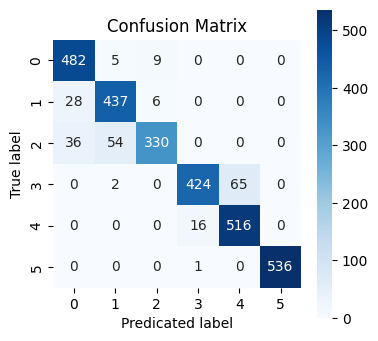

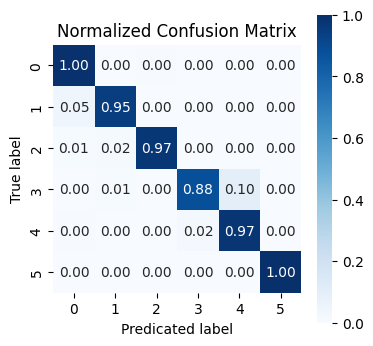

In [34]:
plt.figure(figsize=(4,4))
sns.heatmap(df_cm, square=True, annot=True,fmt='d',cmap=plt.cm.Blues)
plt.title("Confusion Matrix",fontsize = 12)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

plt.figure(figsize=(4,4))
sns.heatmap(df_cm_norm, square=True, fmt=".2f", annot=True,cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 12)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

The model implemented using logistic regression demonstrated better performance in terms of the F1 score compared to the KNN-based model (0.9622 vs 0.9238). Both models exhibited higher precision for classes 1 and 6 ("Walking" and "Lying down," respectively). However, the regression-based model faced greater difficulty with class 4 ("Sitting," TP = 88%), while the KNN-based model showed more difficulty with classes 4 and 3 ("Sitting" and "Descending
